In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv("Avalache_data.csv")

In [3]:
df.head(3)

,Date/Time (PST),Temperature (deg F),Relative Humidity (%),"Total Snow Depth ("")","Intermittent/Shot Snow ("")"
0,25-06-2019 15:00,47.33,89.90,16.46,-7999.0
1,25-06-2019 14:00,53.80,69.82,10.02,-7999.0
2,25-06-2019 13:00,55.02,65.32,12.31,-7999.0


In [4]:
# Split Date/Time into separate columns
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])
df['Year'] = df['Date/Time (PST)'].dt.year
df['Month'] = df['Date/Time (PST)'].dt.month
df['Day'] = df['Date/Time (PST)'].dt.day
df['Hour'] = df['Date/Time (PST)'].dt.hour


In [5]:
# Drop the original Date/Time column
df.drop(columns=['Date/Time (PST)'], inplace=True)

In [6]:
# Handle missing values
# Assuming 'Avlanche Type' is the target variable
df.dropna(subset=['Total Snow Depth (")'], inplace=True)


In [7]:
# Separate features and target variable
X = df.iloc[:,:-1]
y = df['Total Snow Depth (")']


In [8]:
# Define numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


In [9]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [10]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [11]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [12]:
rf_model = RandomForestClassifier(random_state=42)

In [13]:
# Create and evaluate the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model)])


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
y_train.unique()

array([66.53, 95.8 , 88.5 , ..., 27.27, 82.2 , 63.5 ])

In [16]:
# Check if the target variable is continuous
print(y_train.dtype)

float64


In [17]:
rf_reg_model = RandomForestRegressor(random_state=42)


In [18]:
# Create and evaluate the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_reg_model)])


In [19]:
# Fit the model
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Temperature (deg F)', 'Relative Humidity (%)', 'Total Snow Depth (")',
       'Intermittent/Shot Snow (")', 'Year', 'Month', 'Day'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [20]:
# Evaluate the model with cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5)

In [21]:
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [-3.41496602  0.99995818  0.99987525  0.59674917  0.99979434]
Mean cross-validation score: 0.03628218588501338


In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
# Define parameter grid for RandomForestRegressor
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [24]:
# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=2)


In [25]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Temperature (deg F)', 'Relative Humidity (%)', 'Total Snow Depth (")',
       'Intermittent/Shot Snow (")', 'Year', 'Month', 'Day'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([], dtype='object'))])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             verbose=2)

In [26]:
# Display the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best cross-validation score: 0.9987862490039511


In [27]:


# Evaluate the best estimator on the test data
best_clf = grid_search.best_estimator_
test_score = best_clf.score(X_test, y_test)
print("Test score:", (test_score)*100)

Test score: 99.99978349278894


In [28]:
best_clf.score(X_train, y_train)*100

99.99770676308052

In [29]:
best_clf.score(X_test, y_test)*100

99.99978349278894

In [30]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

In [31]:
train_sizes, train_scores, test_scores = learning_curve(best_clf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

In [32]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


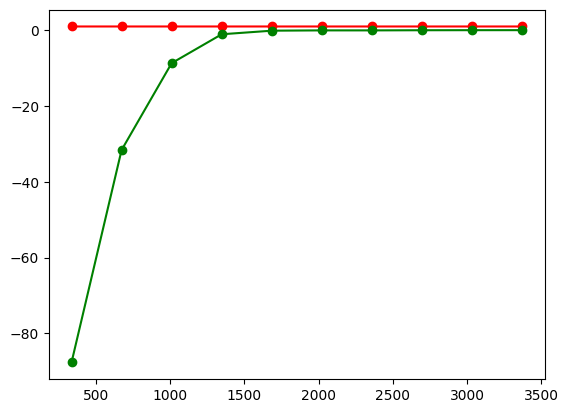

In [33]:
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


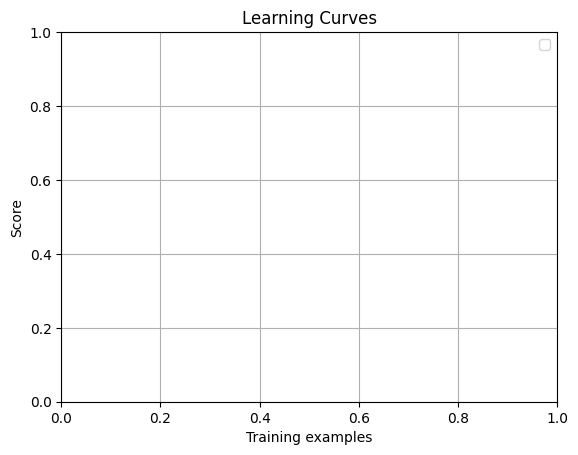

In [34]:
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression